## Introducción al problema planteado

El objetivo de este proyecto es identificar valores atípicos (outliers) en biomarcadores de pacientes para generar un sistema de alerta temprana. Al detectar mediciones de biomarcadores (como presión arterial, temperatura, ritmo cardíaco, glucosa, etc.) que superan los rangos normales, podemos alertar a los profesionales de la salud sobre posibles deterioros en el estado del paciente. Para esta tarea, utilizaremos la base de datos MIMIC-III, una base de datos de libre acceso que contiene información de pacientes hospitalizados en unidades de cuidados intensivos de hospitales de USA.


## Proceso de acotamiento y preparación del dataset
El dataset original de MIMIC-III, debido a su gran tamaño y la forma en que se estructuran los datos de biomarcadores (en formato "largo" o long format), requirió un proceso de acotamiento y preparación para hacerlo manejable para este análisis.

El archivo original contiene una columna que almacena todos los valores de las mediciones de biomarcadores, y otra columna con un identificador o código que especifica qué tipo de biomarcador es (por ejemplo, ritmo cardíaco, temperatura, etc.). Para poder trabajar con las variables de manera individual (un formato "ancho" o wide format), realizamos el siguiente procedimiento:

- Procesamiento por biomarcador: Se procesó el dataset original en chunks (fragmentos) para manejar el gran volumen de datos sin sobrecargar la memoria.

- Filtrado por código: En cada chunk, se filtraron los datos para seleccionar únicamente los biomarcadores de interés (ritmo cardíaco, presión arterial, temperatura, etc.), identificándolos por sus códigos o IDs únicos.

- Extracción y almacenamiento: Los datos filtrados para cada biomarcador se extrajeron y guardaron en archivos CSV separados.

- Ensamblaje del dataset final: Una vez que se extrajeron los datos de cada biomarcador, se ensamblaron en un único DataFrame.

- Organización cronológica: Finalmente, el dataset ensamblado se ordenó por la fecha y hora de la toma de la muestra (CHARTTIME) para asegurar que el análisis de la evolución temporal de los biomarcadores fuera preciso.

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [3]:
ruta_archivo = 'C:/Users/User/Documents/Proyectos_Programacion/MIMIC-Dataset/df_merged_completos.csv'

In [5]:
try:
    df_mimic = pd.read_csv(ruta_archivo)   
except FileNotFoundError:
    print(f"Error: El archivo no se encontró en la ruta: {ruta_archivo}")
except Exception as e:
    print(f"Ocurrió un error al intentar leer el archivo: {e}")

C:\Users\User\AppData\Local\Temp\ipykernel_40432\1573887277.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mimic = pd.read_csv(ruta_archivo)


In [7]:
df_mimic.head()

,SUBJECT_ID,HADM_ID,CHARTTIME,HEART_RATE_VALUE,HEART_RATE_UOM,TEMPERATURE_VALUE,TEMPERATURE_UOM,OXYGEN_SAT_VALUE,OXYGEN_SAT_UOM,BLOOD_DIASTOLIC_VALUE,BLOOD_DIASTOLIC_UOM,BLOOD_SYSTOLIC_VALUE,BLOOD_SYSTOLIC_UOM,GLUCOSE_VALUE,GLUCOSE_UOM
0,2,163353,2138-07-17 20:20:00,148.0,bpm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,163353,2138-07-17 20:30:00,131.0,bpm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,163353,2138-07-17 21:00:00,144.0,bpm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,163353,2138-07-17 22:00:00,140.0,bpm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,145834,2101-10-20 18:45:00,95.0,BPM,NaN,NaN,98.0,%,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_mimic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9028427 entries, 0 to 9028426
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SUBJECT_ID             int64  
 1   HADM_ID                int64  
 2   CHARTTIME              object 
 3   HEART_RATE_VALUE       float64
 4   HEART_RATE_UOM         object 
 5   TEMPERATURE_VALUE      float64
 6   TEMPERATURE_UOM        object 
 7   OXYGEN_SAT_VALUE       float64
 8   OXYGEN_SAT_UOM         object 
 9   BLOOD_DIASTOLIC_VALUE  float64
 10  BLOOD_DIASTOLIC_UOM    object 
 11  BLOOD_SYSTOLIC_VALUE   float64
 12  BLOOD_SYSTOLIC_UOM     object 
 13  GLUCOSE_VALUE          object 
 14  GLUCOSE_UOM            object 
dtypes: float64(5), int64(2), object(8)
memory usage: 1.0+ GB


## Descripción de la base de datos
La base de datos utilizada para este análisis es la MIMIC-III. A continuación, se detalla su estructura, número de registros, variables y tipos de datos.

*Estructura y tamaño*: La base de datos contiene 9,028,427 registros y 15 columnas.

### Variables y tipos de datos:



| Nombre de la variable      | Descripción (qué significa)                  | Codificación (tipo de variable) | Significado clínico (fundamental)                       |
|----------------------------|----------------------------------------------|---------------------------------|---------------------------------------------------------|
| SUBJECT_ID                 | Identificador único del paciente en todo el dataset. Se mantiene igual en todas sus estancias.             | int64                           | Identifica al paciente                                  |
| HADM_ID                    | Identificador del ingreso hospitalario del paciente. Cada vez que el paciente es admitido, se genera uno nuevo.    | int64                           | Identifica el episodio de hospitalización               |
| CHARTTIME                  | Marca de tiempo en la que se registró la observación.                  | object (timestamp/string)       | Indica cuándo se tomó el dato                           |
| HEART_RATE_VALUE           | Frecuencia cardíaca (latidos por minuto)     | float64                         | Evalúa ritmo cardíaco: bajo, normal o elevado           |
| HEART_RATE_UOM             | Unidad de frecuencia cardíaca                | object                          | Usualmente bpm                                          |
| TEMPERATURE_VALUE          | Temperatura corporal                         | float64                         | Indica fiebre, normalidad o hipotermia                  |
| TEMPERATURE_UOM            | Unidad de temperatura                        | object                          | Usualmente °C                                           |
| OXYGEN_SAT_VALUE           | Saturación de oxígeno en sangre              | float64                         | Evalúa nivel de oxigenación                             |
| OXYGEN_SAT_UOM             | Unidad de saturación de oxígeno              | object                          | Usualmente %                                            |
| BLOOD_DIASTOLIC_VALUE      | Presión arterial diastólica                  | float64                         | Evalúa presión mínima arterial                          |
| BLOOD_DIASTOLIC_UOM        | Unidad presión diastólica                    | object                          | Usualmente mmHg                                         |
| BLOOD_SYSTOLIC_VALUE       | Presión arterial sistólica                   | float64                         | Evalúa presión máxima arterial                          |
| BLOOD_SYSTOLIC_UOM         | Unidad presión sistólica                     | object                          | Usualmente mmHg                                         |
| GLUCOSE_VALUE              | Nivel de glucosa en sangre                   | object (numérico tipo string)   | Evalúa control glucémico                                |
| GLUCOSE_UOM                | Unidad de glucosa en sangre                  | object                          | Usualmente mg/dL                                        |



## Acotaciones
Para este trabajo acotaremos las muestras del dataset a los primero 100.000 registros, primero que todo 
para no tener sesgos en la muestra del dataset de informacion y que sea totalmente transparente el analisis poblacional 

In [9]:
# Acotar el DataFrame a los primeros 100,000 registros
df_acotado = df_mimic.head(100000)

print(f"Número de registros del dataset original: {len(df_mimic)}")
print(f"Número de registros del dataset acotado: {len(df_acotado)}")

Número de registros del dataset original: 9028427
Número de registros del dataset acotado: 100000


In [10]:
df_acotado = df_acotado.rename(columns={
    "HEART_RATE_VALUE": "HEART_RATE",
    "TEMPERATURE_VALUE": "TEMPERATURE",
    "OXYGEN_SAT_VALUE": "OXYGEN_SAT",
    "BLOOD_DIASTOLIC_VALUE": "DIASTOLIC_BP",
    "BLOOD_SYSTOLIC_VALUE": "SYSTOLIC_BP",
    "GLUCOSE_VALUE": "GLUCOSE",
})

##
### Clasificación artificial del estado del paciente

Con el fin de enriquecer el dataset, haremos uso de una función para crear una columna con una **"etiqueta artificial"** (`PATIENT_STATE`) que representa el estado clínico estimado del paciente durante la remisión o ingreso hospitalario.  
Esta etiqueta busca reflejar si el ingreso fue normal o si el paciente parecía presentar —o se sospechaba que podía tener— alguna condición crítica según sus signos vitales.

La función asigna el estado clínico a cada registro en base a **umbrales clínicos comúnmente aceptados**.  
Para garantizar coherencia, se estableció un **orden de prioridad**, de modo que si un paciente cumplía con más de una condición, se seleccionaba la más crítica.

---

#### Reglas de clasificación aplicadas

- **Glucosa**
  - `≥ 200` → *Diabetes*  
  - `< 70` → *Hipoglucemia*  

- **Oxigenación**
  - `OXYGEN_SAT ≤ 88` → *Apnea*  

- **Presión arterial**
  - `Sistólica ≥ 140` o `Diastólica ≥ 90` → *Hipertensión*  
  - `Sistólica < 90` o `Diastólica < 60` → *Hipotensión*  

- **Frecuencia cardíaca**
  - `HEART_RATE > 100` → *Taquicardia*  
  - `HEART_RATE < 60` → *Bradicardia*  

- **Temperatura**
  - `≥ 100.4 °F` → *Fiebre*  
  - `< 95 °F` → *Hipotermia*  

- **Si ninguna condición aplica → Normal**  


### Reglas de clasificación aplicadas 


| Condición simulada                | Columna(s) utilizada(s)                  | Regla (simplificada)                 |
| --------------------------------- | ---------------------------------------- | ------------------------------------ |
| **Diabetes (sospecha)**           | `GLUCOSE`                                | ≥ 200 mg/dL                          |
| **Hipoglucemia**                  | `GLUCOSE`                                | < 70 mg/dL                           |
| **Apnea respiratoria (sospecha)** | `OXYGEN_SAT`                             | ≤ 88%                                |
| **Hipertensión**                  | `SYSTOLIC_BP`, `DIASTOLIC_BP`            | Sistólica ≥ 140 **o** Diastólica ≥ 90 |
| **Hipotensión**                   | `SYSTOLIC_BP`, `DIASTOLIC_BP`            | Sistólica < 90 **o** Diastólica < 60  |
| **Taquicardia**                   | `HEART_RATE`                             | > 100 bpm                            |
| **Bradicardia**                   | `HEART_RATE`                             | < 60 bpm                             |
| **Fiebre**                        | `TEMPERATURE`                            | ≥ 100.4 °F (38 °C)                   |
| **Hipotermia**                    | `TEMPERATURE`                            | < 95 °F (35 °C)                      |
| **Normal**                        | *Todas las anteriores no aplican*        |                                      |


In [22]:
def create_patient_state(df):
    df = df.copy()
    df['GLUCOSE'] = pd.to_numeric(df['GLUCOSE'], errors='coerce')

    # Inicializamos como "Normal"
    df['PATIENT_STATE'] = "Normal"

    # Reglas con prioridad (lo más grave primero)
    df.loc[df['GLUCOSE'] >= 200, 'PATIENT_STATE'] = "Diabetes"
    df.loc[df['GLUCOSE'] < 70, 'PATIENT_STATE'] = "Hipoglucemia"
    df.loc[df['OXYGEN_SAT'] <= 88, 'PATIENT_STATE'] = "Apnea"
    df.loc[(df['SYSTOLIC_BP'] >= 140) | (df['DIASTOLIC_BP'] >= 90), 'PATIENT_STATE'] = "Hipertension"
    df.loc[(df['SYSTOLIC_BP'] < 90) | (df['DIASTOLIC_BP'] < 60), 'PATIENT_STATE'] = "Hipotension"
    df.loc[df['HEART_RATE'] > 100, 'PATIENT_STATE'] = "Taquicardia"
    df.loc[df['HEART_RATE'] < 60, 'PATIENT_STATE'] = "Bradicardia"
    df.loc[df['TEMPERATURE'] >= 100.4, 'PATIENT_STATE'] = "Fiebre"
    df.loc[df['TEMPERATURE'] < 95, 'PATIENT_STATE'] = "Hipotermia"

    return df

# Aplicamos la función al dataframe acotado
df_acotado = create_patient_state(df_acotado)

# Revisamos las primeras filas
df_acotado.head()


,SUBJECT_ID,HADM_ID,CHARTTIME,HEART_RATE,HEART_RATE_UOM,TEMPERATURE,TEMPERATURE_UOM,OXYGEN_SAT,OXYGEN_SAT_UOM,DIASTOLIC_BP,BLOOD_DIASTOLIC_UOM,SYSTOLIC_BP,BLOOD_SYSTOLIC_UOM,GLUCOSE,GLUCOSE_UOM,PATIENT_STATE
0,2,163353,2138-07-17 20:20:00,148.0,bpm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Taquicardia
1,2,163353,2138-07-17 20:30:00,131.0,bpm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Taquicardia
2,2,163353,2138-07-17 21:00:00,144.0,bpm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Taquicardia
3,2,163353,2138-07-17 22:00:00,140.0,bpm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Taquicardia
4,3,145834,2101-10-20 18:45:00,95.0,BPM,NaN,NaN,98.0,%,NaN,NaN,NaN,NaN,NaN,NaN,Normal


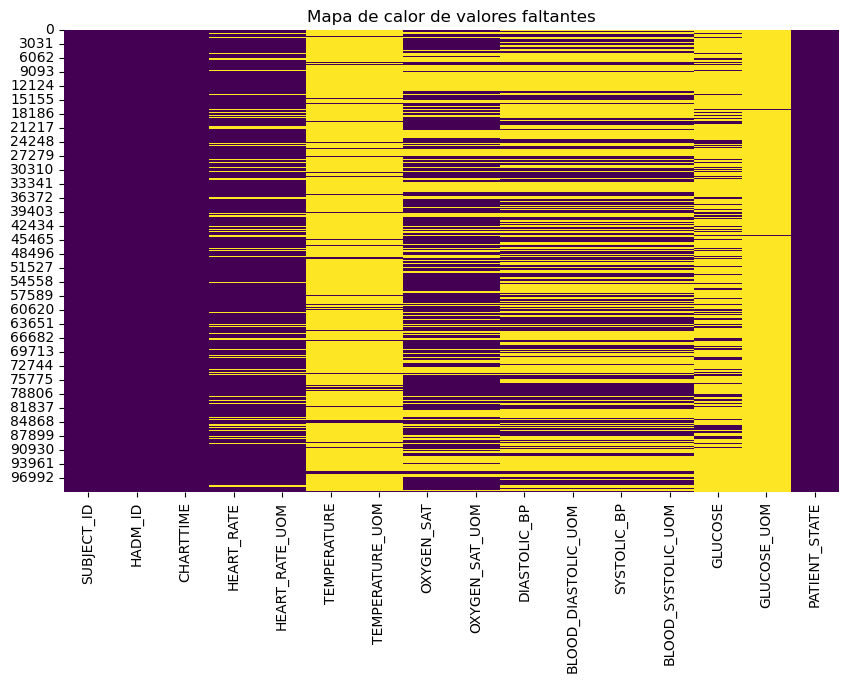

In [23]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_acotado.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de calor de valores faltantes')
plt.show()

In [24]:
# Conteo de valores faltantes
faltantes = df_acotado.isnull().sum()

# Filtrar solo variables con valores faltantes
faltantes = faltantes[faltantes > 0].sort_values(ascending=False)

# Calcular % de valores faltantes
porcentaje = (faltantes / len(df_acotado)) * 100

# Mostrar resultado
print("\nConteo y porcentaje de valores faltantes por variable:")
print(pd.DataFrame({
    'Faltantes': faltantes,
    'Porcentaje (%)': porcentaje.round(2)
}))



Conteo y porcentaje de valores faltantes por variable:
                     Faltantes  Porcentaje (%)
GLUCOSE_UOM              99668           99.67
TEMPERATURE              92250           92.25
TEMPERATURE_UOM          92243           92.24
GLUCOSE                  80745           80.74
DIASTOLIC_BP             58660           58.66
BLOOD_DIASTOLIC_UOM      58653           58.65
SYSTOLIC_BP              58653           58.65
BLOOD_SYSTOLIC_UOM       58618           58.62
OXYGEN_SAT               36125           36.12
OXYGEN_SAT_UOM           36008           36.01
HEART_RATE               12759           12.76
HEART_RATE_UOM           12664           12.66


###
Como se puede observar en las imagenes anteriores de los mapas de calor en datos faltantes hay columnas las cuales en su mayoria estan vacias, pero haciendo un poco de exploracion para saber que contenian estos datos, basicamente es el valor de la medida por ejemplo en saturacion de oxigeno se mide en porcentaje con el simbolo "%"  asi que algunos de ellos se podrian llenar manualmente, pues se usa la misma medida, o validar por paciente y encontrar si alguna de sus columnas tiene el valor correspondiente, otros datos faltantes son simplemente por que no se toma el dato de los biomarcadores simultaneamente o a la misma hora en un paciente en un ingreso hospitalario.
###

In [25]:
biomarcadores = ['HEART_RATE', 'TEMPERATURE', 'OXYGEN_SAT', 
                 'DIASTOLIC_BP', 'SYSTOLIC_BP', 'GLUCOSE']

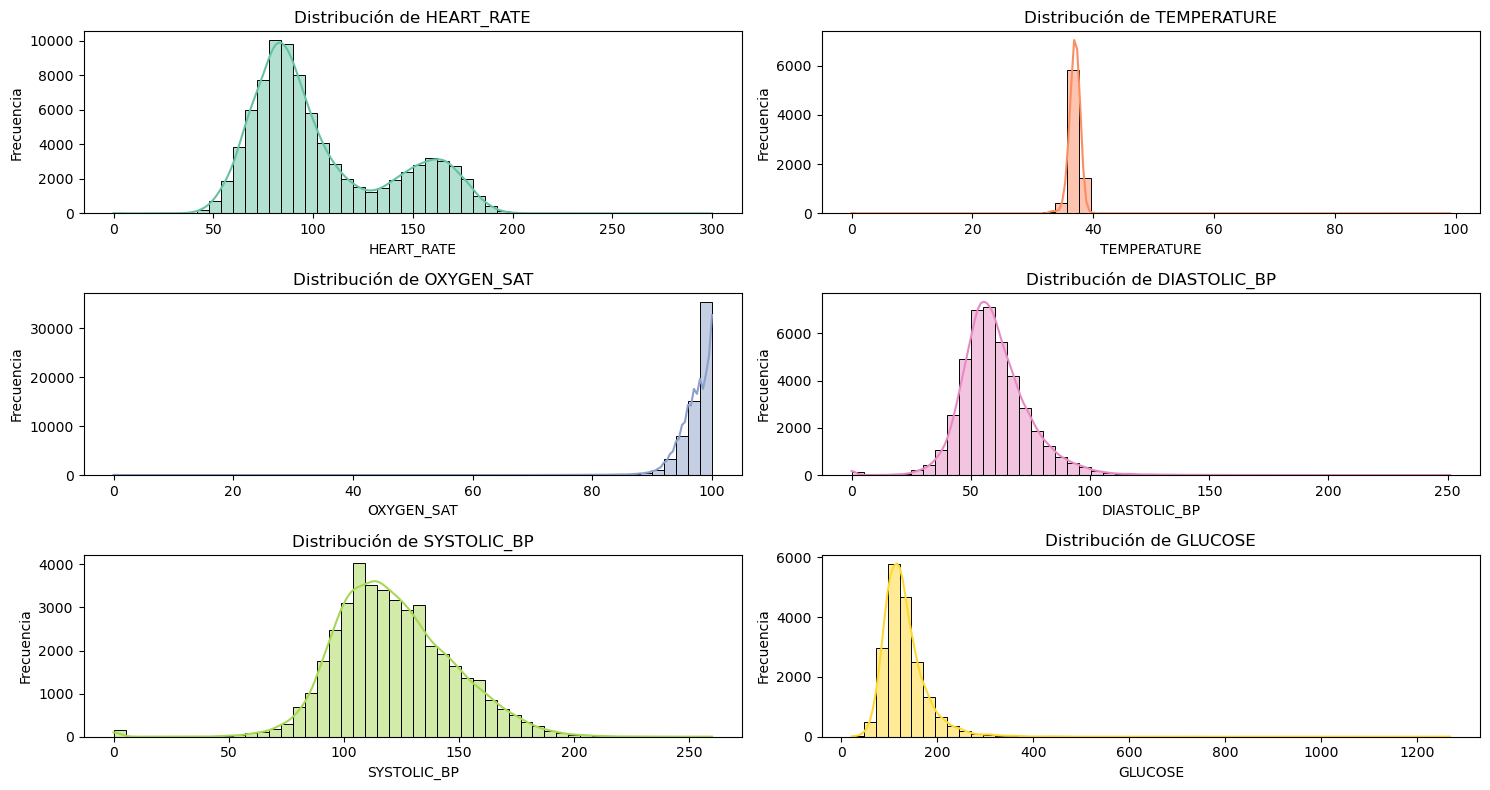

In [31]:
colors = sns.color_palette("Set2", 6)
fig, axes = plt.subplots(3, 2, figsize=(15, 8))
axes = axes.flatten()  # convertir a lista plana para iterar fácil

# Graficar cada biomarcador en su subplot
for i, col in enumerate(biomarcadores):
    sns.histplot(df_acotado[col].dropna(), kde=True, bins=50, ax=axes[i], color=colors[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Eliminar subplots vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

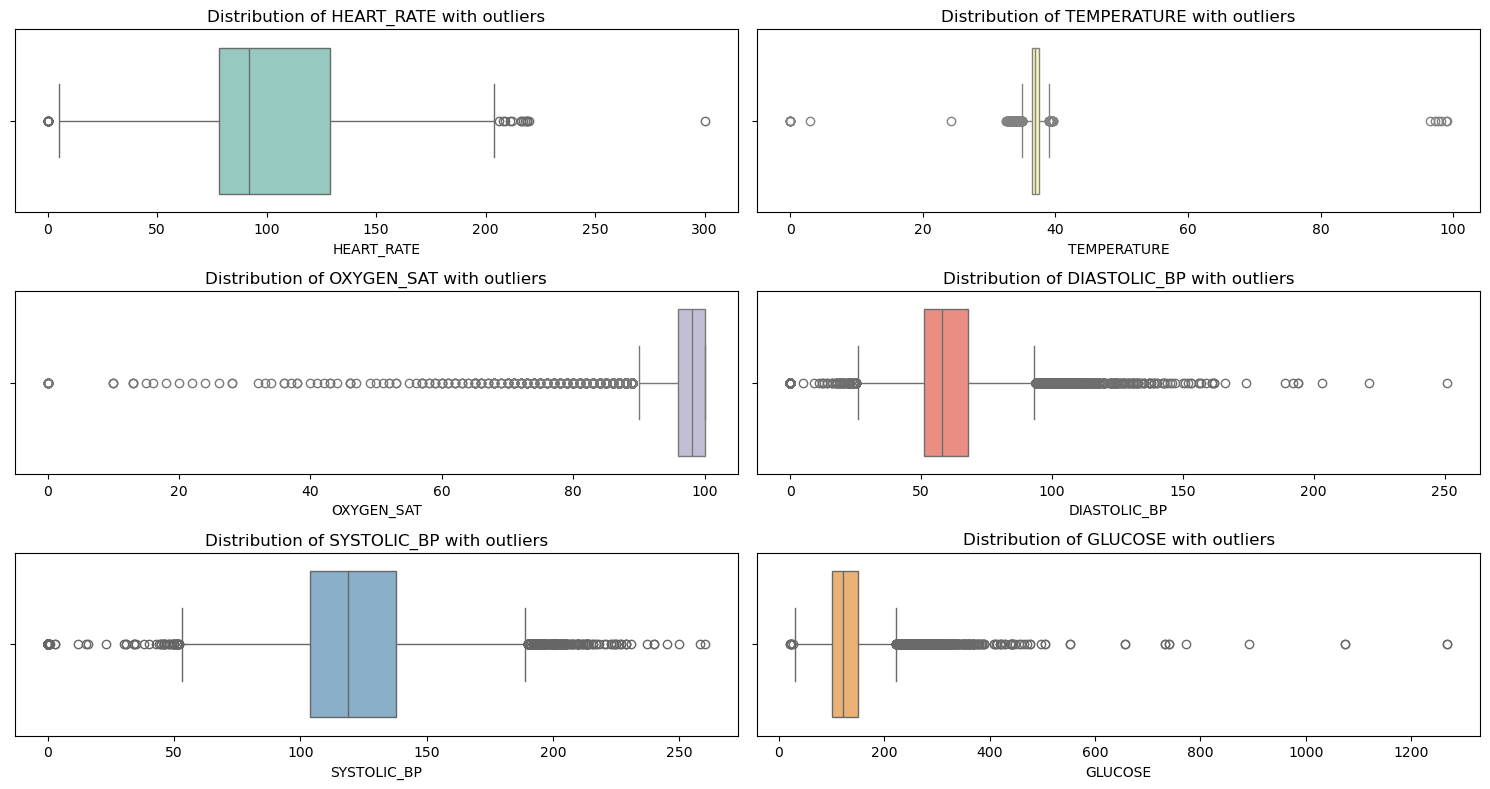

In [27]:
colors = sns.color_palette("Set3", 6)

fig, axes = plt.subplots(3, 2, figsize=(15, 8))
axes = axes.flatten()

# Graficar cada boxplot con color distinto
for i, col in enumerate(biomarcadores):
    sns.boxplot(x=df_acotado[col].dropna(), ax=axes[i], color=colors[i])
    axes[i].set_title(f'Distribution of {col} with outliers')
    axes[i].set_xlabel(col)

# Eliminar subplots vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

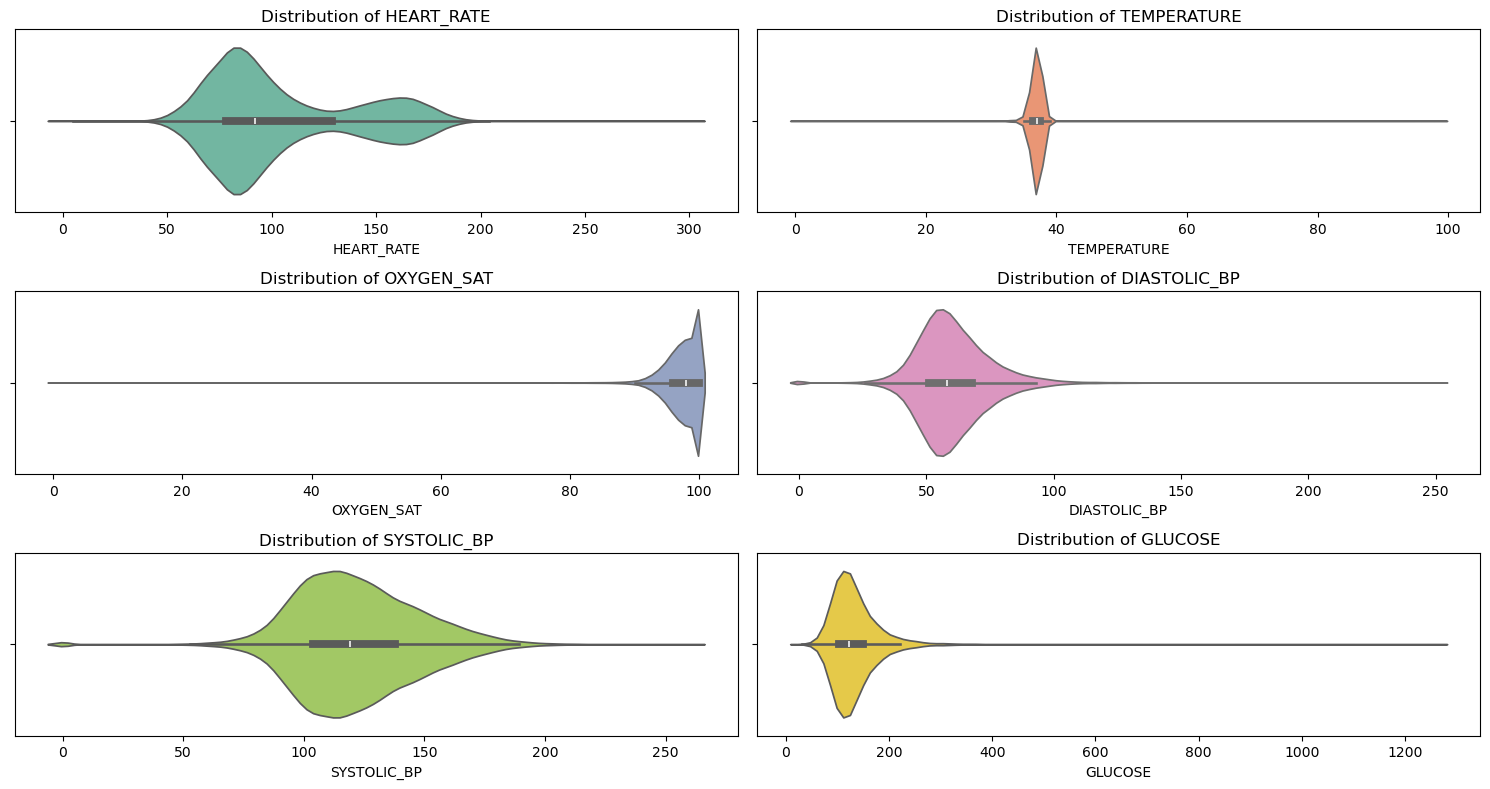

In [28]:
colors = sns.color_palette("Set2", 6)
fig, axes = plt.subplots(3, 2, figsize=(15, 8))
axes = axes.flatten()

# Graficar cada violin plot
for i, col in enumerate(biomarcadores):
    sns.violinplot(x=df_acotado[col].dropna(), ax=axes[i], color=colors[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)

# Eliminar subplots vacíos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_40432\4034226051.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


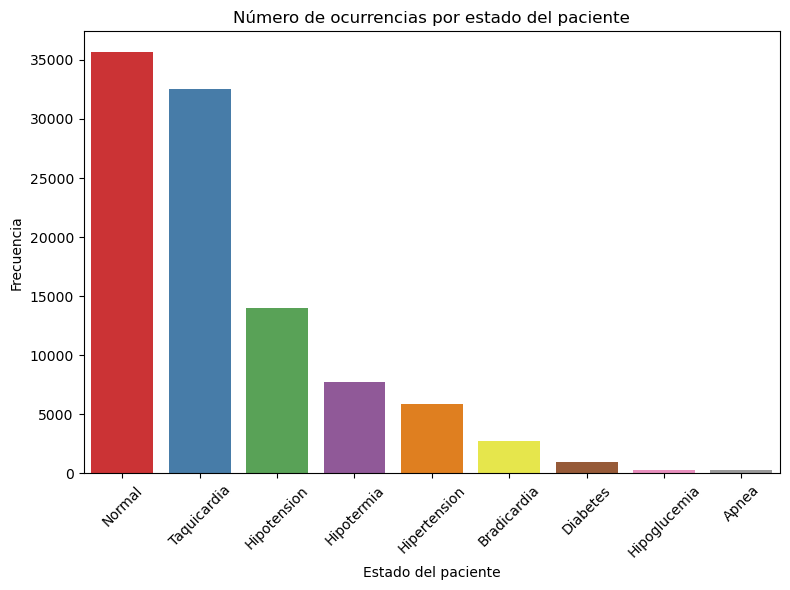

Tabla de frecuencias de 'PATIENT_STATE' :

  PATIENT_STATE  count  percentage
0        Normal  35630       35.63
1   Taquicardia  32521       32.52
2   Hipotension  13971       13.97
3    Hipotermia   7744        7.74
4  Hipertension   5891        5.89
5   Bradicardia   2727        2.73
6      Diabetes    941        0.94
7  Hipoglucemia    297        0.30
8         Apnea    278        0.28


In [56]:
# Ordenar las etiquetas de mayor a menor
order = df_acotado["PATIENT_STATE"].value_counts().index

plt.figure(figsize=(8,6))
sns.countplot(
    x="PATIENT_STATE",
    data=df_acotado,
    order=order,
    palette=colors
)

plt.title("Número de ocurrencias por estado del paciente")
plt.xlabel("Estado del paciente")
plt.ylabel("Frecuencia")

# Rotar etiquetas si hay muchas
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
# --- Tabla de conteos y proporciones ---
state_counts = (
    df_acotado["PATIENT_STATE"]
    .value_counts()
    .reset_index()  # crea columnas: "index" y "PATIENT_STATE"
)

# Renombrar columnas de forma explícita
state_counts.columns = ["PATIENT_STATE", "count"]

# Añadir columna con porcentaje
state_counts["percentage"] = (state_counts["count"] / state_counts["count"].sum() * 100).round(2)

print("Tabla de frecuencias de 'PATIENT_STATE' :\n")
print (state_counts)


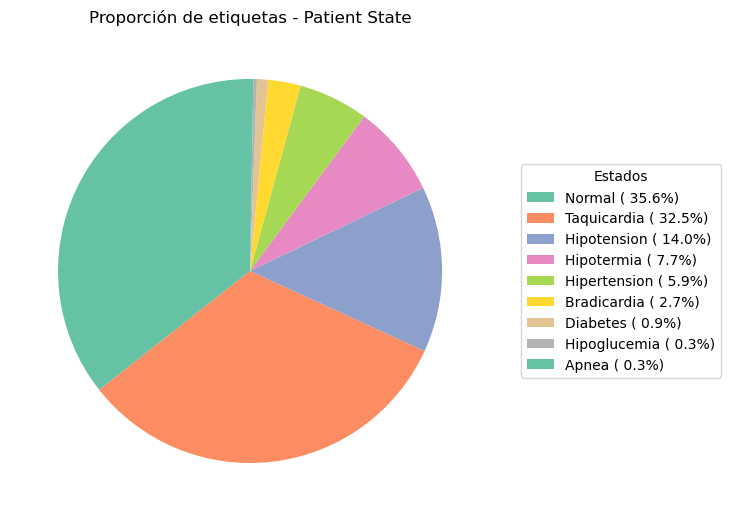

In [42]:
plt.figure(figsize=(7,6))

# Pie sin texto
df_acotado["PATIENT_STATE"].value_counts().plot.pie(
    colors=colors,
    startangle=90,
    labels=None
)

plt.title("Proporción de etiquetas - Patient State")
plt.ylabel("")

# Leyenda con etiquetas + porcentajes
counts = df_acotado["PATIENT_STATE"].value_counts()
labels = [f"{idx} ( {val/sum(counts)*100:.1f}%)" for idx, val in counts.items()]

plt.legend(
    labels=labels,
    title="Estados",
    bbox_to_anchor=(1.05, 0.5),
    loc="center left"
)

plt.tight_layout()
plt.show()


La gráfica de proporciones muestra cómo se distribuyen las etiquetas tras aplicar estas reglas:

- Normal (35.6%) y Taquicardia (32.5%) concentran la mayor parte de los casos, lo cual refleja que la población analizada oscila entre parámetros estables y elevaciones en la frecuencia cardíaca.

- Condiciones frecuentes adicionales fueron Hipotensión (14.0%), Hipotermia (7.7%) e Hipertensión (5.9%), que capturan alteraciones importantes en presión arterial y temperatura.

- Estados menos frecuentes, pero de alta relevancia clínica, incluyen Bradicardia (2.7%), Diabetes (0.9%), Hipoglucemia (0.3%) y Apnea (0.3%).

Este resultado también refleja la influencia del orden de prioridad en las reglas: por ejemplo, un paciente con glucosa elevada y presión alta será etiquetado como Diabetes, ya que esta condición tiene mayor prioridad en la jerarquía de riesgo.

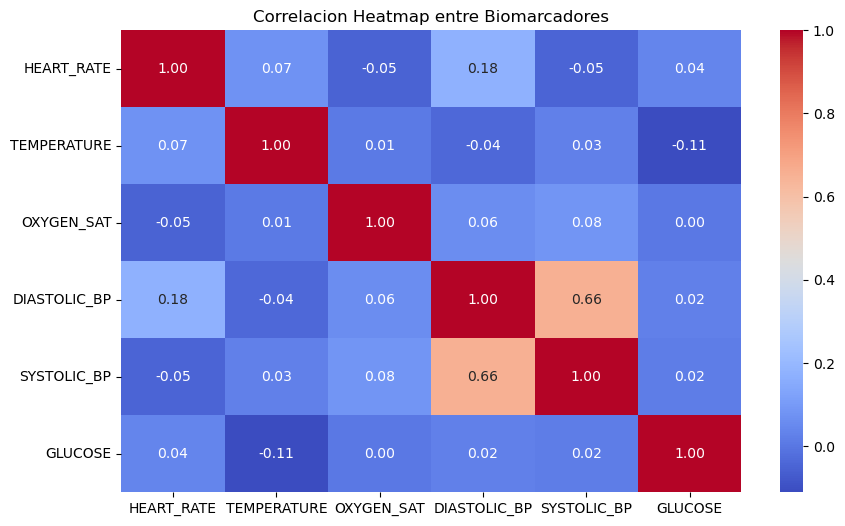

In [44]:
numeric_biomarcadores = df_acotado[biomarcadores].select_dtypes(include=['number'])

plt.figure(figsize=(10,6))
corr = numeric_biomarcadores.corr()  # Calculate correlation only on numeric columns
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlacion Heatmap entre Biomarcadores")
plt.show()

## Interpretación de las visualizaciones exploratorias

Los histogramas muestran dos tipos de distribución para los biomarcadores:

- Valores concentrados: La saturación de oxígeno y la temperatura se agrupan en un rango estrecho y clínicamente normal (p. ej., saturación alta, temperatura cerca de 37°C). Esto es esperado, ya que desviaciones significativas de estos valores indicarían un estado de salud crítico en el paciente; aun que en otros valores resultan ser muy atipicos, demasiado extremos, la hipotesis inicial es que probablemente se hayan medido con escalas numericas propias que se usan comunmente en Estados Unidos por ejemplo XX **°F**.

- Distribución normal: Otros biomarcadores, como la presión sistólica, presentan una distribución más cercana a la normal (en forma de campana). Esto indica que los valores se agrupan alrededor de un promedio.

- El dataset resulta prometedor para la tarea de deteccion de datos atipicos en pacientes pues se puede apreciar que este posee demasiadas anomalias

- Los gráficos de bigotes revelan la presencia de una alta cantidad de datos atípicos (outliers) en los biomarcadores, lo que es de gran relevancia clínica.

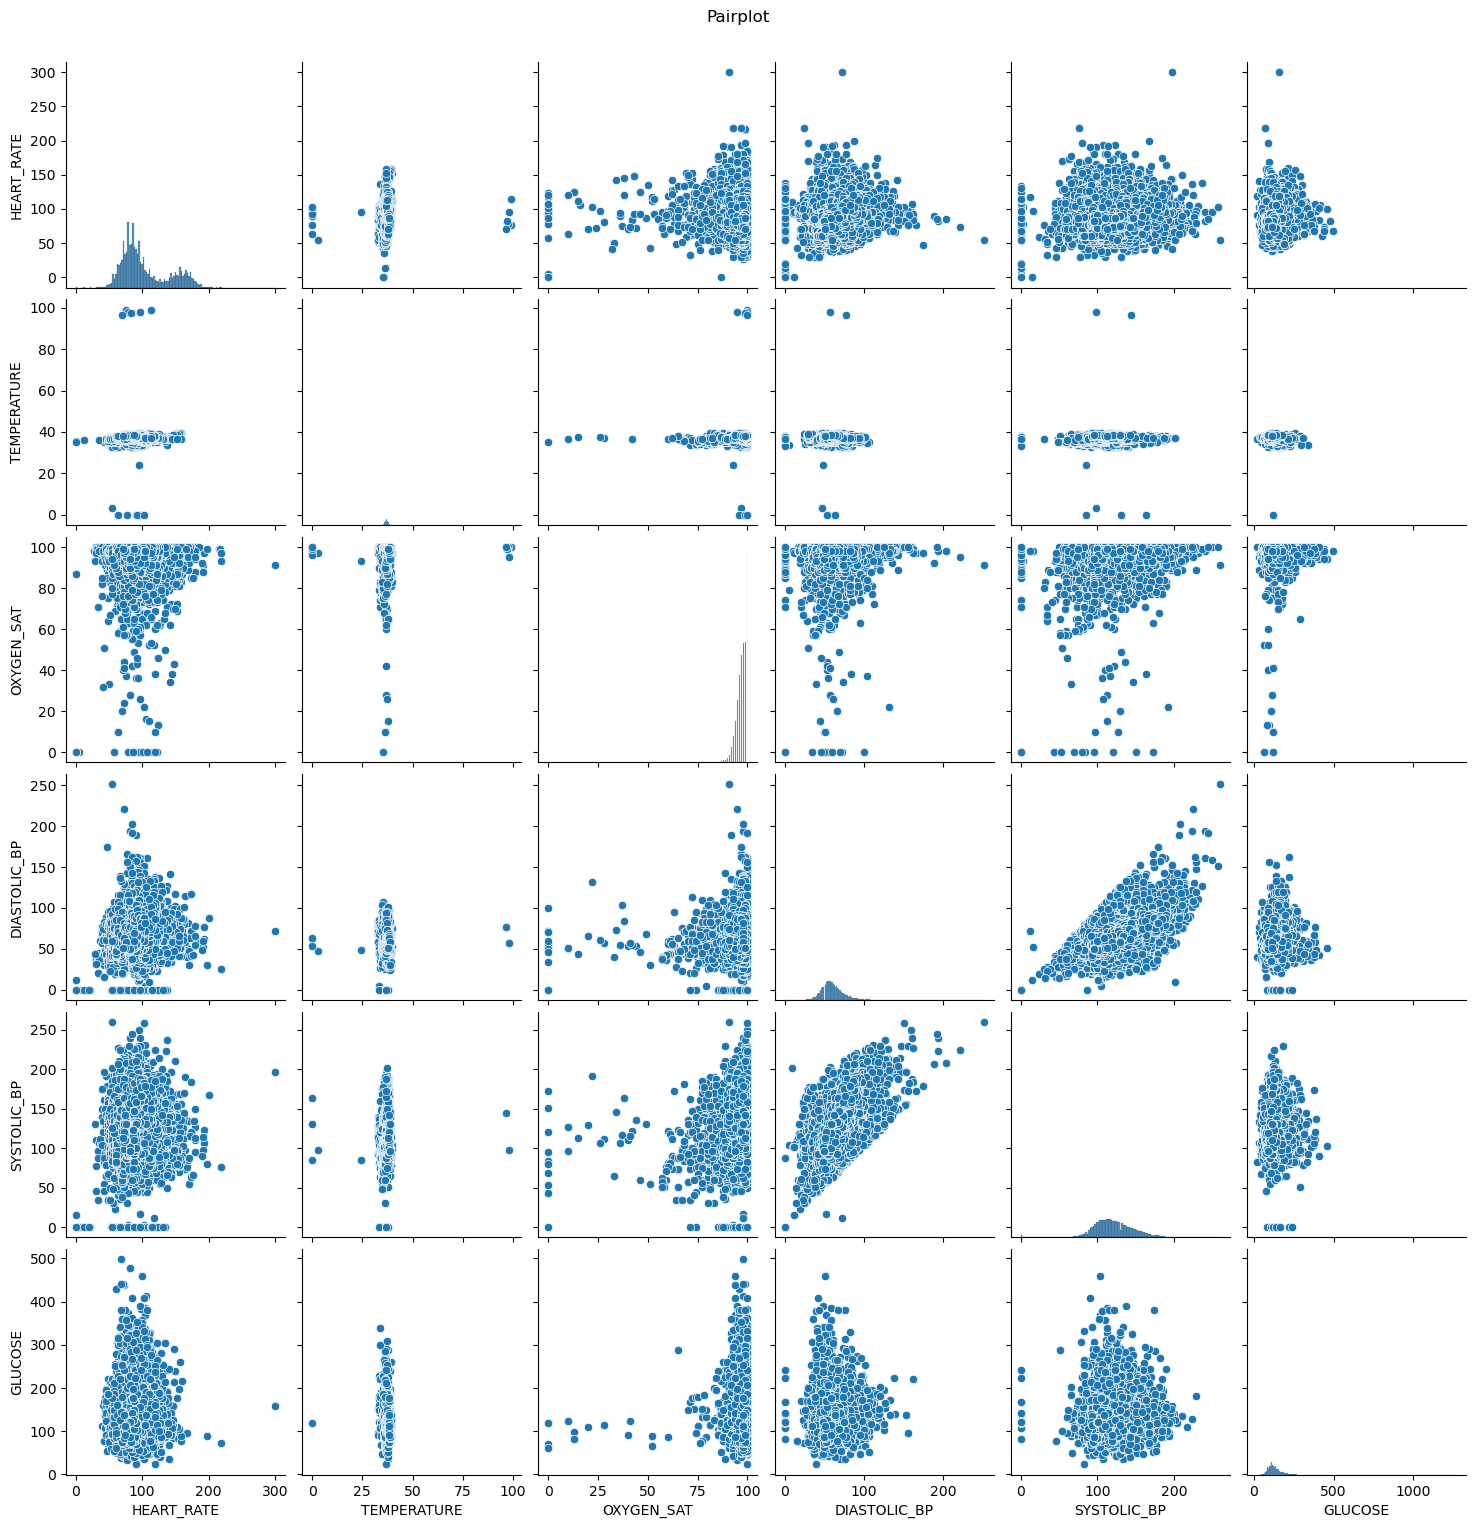

In [57]:
# Graficamos un scatter pairplot
sns.pairplot(numeric_biomarcadores)
plt.suptitle('Pairplot', y=1.02)
plt.show()

### Pairplot

El análisis de correlación visual entre biomarcadores muestra lo siguiente:

- **Distribución individual**  
  - La mayoría de biomarcadores presentan concentraciones claras de valores dentro de rangos normales, pero con presencia visible de outliers extremos, especialmente en **ritmo cardíaco (HEART_RATE)**, **glucosa (GLUCOSE)** y **oxigenación (OXYGEN_SAT)**.  
  - La **temperatura (TEMPERATURE)** se concentra en un rango muy estrecho, con pocos valores atípicos extremos, lo que concuerda con los resultados obtenidos mediante Z-score e IQR.  

- **Relaciones entre variables**  
  - Se observa una **fuerte correlación lineal entre presión sistólica y diastólica (SYSTOLIC_BP y DIASTOLIC_BP)**, lo que confirma que ambas medidas se comportan de manera similar.  
  - En cambio, variables como **ritmo cardíaco, glucosa u oxigenación** no muestran una correlación lineal clara con los otros biomarcadores, lo que sugiere que aportan información complementaria y no redundante.  

- **Identificación de outliers**  
  - Los puntos dispersos alejados de las nubes principales representan **valores atípicos evidentes** que justifican la necesidad de técnicas de detección robustas.  
  - Algunos outliers extremos, como valores de glucosa muy altos o ritmos cardíacos superiores a 200 bpm, son clínicamente críticos y no deben eliminarse, sino aprovecharse para generar alertas.  

En general, el gráfico confirma que el dataset presenta un núcleo de valores normales junto con un conjunto reducido, pero relevante, de datos atípicos que constituyen la base del sistema de alerta temprana.


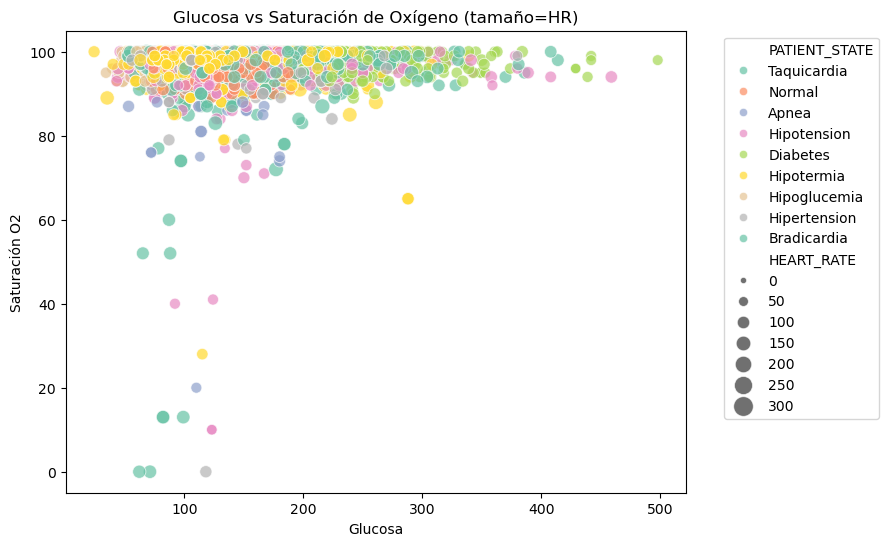

In [59]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_acotado,
    x="GLUCOSE",
    y="OXYGEN_SAT",
    hue="PATIENT_STATE",
    size="HEART_RATE",
    sizes=(20,200),
    palette="Set2",
    alpha=0.7
)
plt.title("Glucosa vs Saturación de Oxígeno (tamaño=HR)")
plt.xlabel("Glucosa")
plt.ylabel("Saturación O2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Deteccion datos atipicos

Como el objetivo de este proyecto es la deteccion de datos atipicos contamos con un dataset enriquecido de tanto datos normales como valores que se salen de la media de valores nosmales de signos vitales para las personas en algunos casos, en otras no se garantiza la presencia de estos pues vaores muy altos o muy bajos podrian significar en este contexto que la persona esta demasiado critica de salud y posiblemente poniendo en riesgo la propia vida de la persona, en este caso veremos el comportamiento de los datos y que tan atipicos son en general y no por paciente ni por engreso, dando una vista general del panorama de los datos 

Cantidad de outliers (Z-score > 2):
HEART_RATE      3289
TEMPERATURE       15
OXYGEN_SAT      1085
DIASTOLIC_BP    1923
SYSTOLIC_BP     1707
GLUCOSE          676
dtype: int64

Cantidad de outliers (Z-score > 3):
HEART_RATE       11
TEMPERATURE      15
OXYGEN_SAT      527
DIASTOLIC_BP    518
SYSTOLIC_BP     288
GLUCOSE         250
dtype: int64


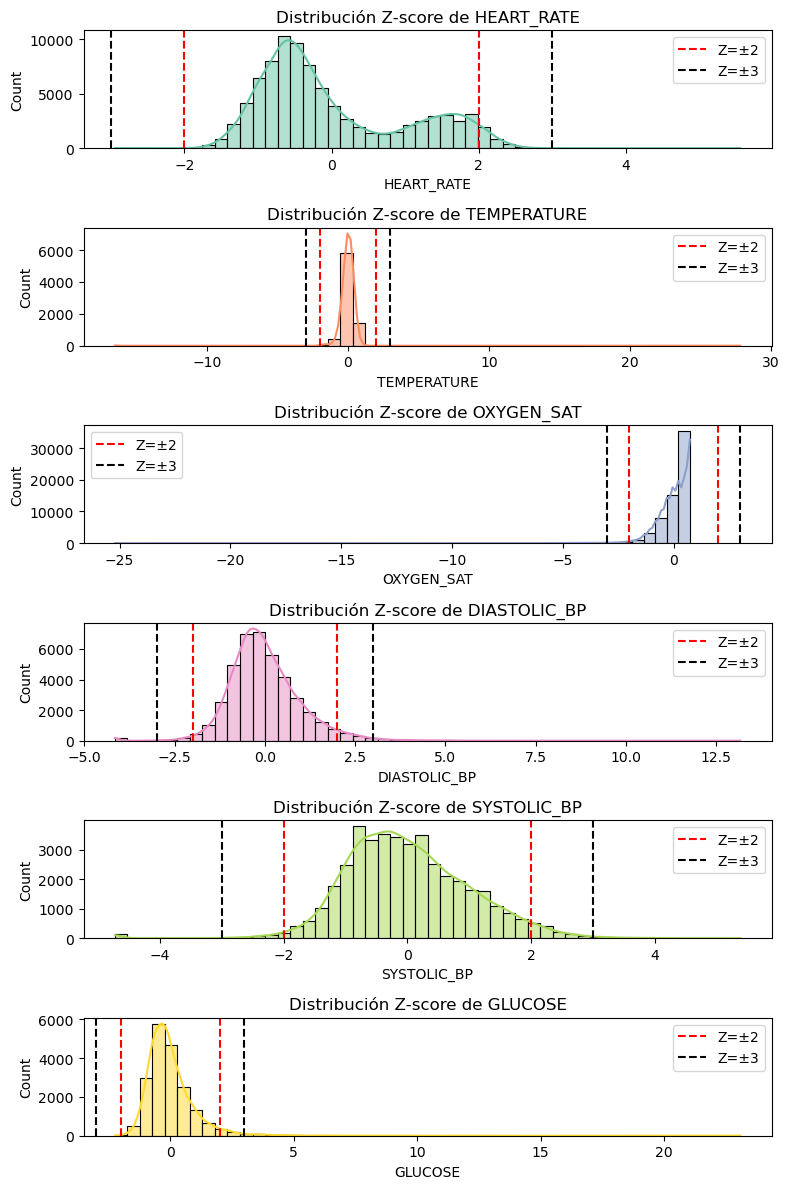

In [84]:
# 1. Convertir a numérico (importante para GLUCOSE que suele ser object)
for col in biomarcadores:
    df_acotado[col] = pd.to_numeric(df_acotado[col], errors="coerce")

# 2. Calcular Z-scores ignorando NaN
z_scores = df_acotado[biomarcadores].apply(lambda x: zscore(x, nan_policy='omit'))

# 3. Detectar outliers (umbral=2 y 3)
outliers_2 = (np.abs(z_scores) > 2).sum()
outliers_3 = (np.abs(z_scores) > 3).sum()

print("Cantidad de outliers (Z-score > 2):")
print(outliers_2)
print("\nCantidad de outliers (Z-score > 3):")
print(outliers_3)

# 4. Graficar histogramas de los Z-scores
colors = sns.color_palette("Set2", len(biomarcadores))

fig, axes = plt.subplots(len(biomarcadores), 1, figsize=(8, 12))
for i, col in enumerate(biomarcadores):
    sns.histplot(z_scores[col].dropna(), bins=50, kde=True, ax=axes[i], color=colors[i])
    axes[i].axvline(2, color="red", linestyle="--", label="Z=±2")
    axes[i].axvline(-2, color="red", linestyle="--")
    axes[i].axvline(3, color="black", linestyle="--", label="Z=±3")
    axes[i].axvline(-3, color="black", linestyle="--")
    axes[i].set_title(f"Distribución Z-score de {col}")
    axes[i].legend()

plt.tight_layout()
plt.show()

###
Con el análisis del Z-score se logro identificar la cantidad de valores atípicos presentes en los biomarcadores seleccionados. Los resultados muestran que:

Con un umbral de Z-score > 2, se detecta un mayor número de valores atípicos, lo que permite capturar variaciones más amplias respecto a la media.

Con un umbral más estricto de Z-score > 3, se identifican menos outliers, pero corresponden a desviaciones más extremas y, por tanto, más significativas desde el punto de vista clínico.

La decisión de explorar ambos umbrales responde a la necesidad de evaluar la sensibilidad del sistema frente a diferentes niveles de anomalía. Usar Z > 2 nos ayuda a captar posibles desviaciones tempranas o moderadas que podrían anticipar un deterioro clínico, mientras que Z > 3 permite enfocarse en casos más severos que representan un riesgo inmediato para el paciente.

Tambien por la gran densidad en algunos datos detectar datos tipicos extremos es algo subjetivo por que aunque los datos esten concentrados en valores muy parecidos las colas que se pueden apreciar en los datos son lo suficientemente pronunciadas o muy lejanas del centro de los datos pueden dar interpretaciones no tan claras al no ser un experto en los datos o el area de aplicacion de este analisis, asi que de momento me limito a solo exponer el porque de las desiciones y que se puede observar a simple vista al aplicar esta metrica al dataset
###

Cantidad de outliers por IQR:
{'HEART_RATE': np.int64(35), 'TEMPERATURE': np.int64(172), 'OXYGEN_SAT': np.int64(1085), 'DIASTOLIC_BP': np.int64(1217), 'SYSTOLIC_BP': np.int64(476), 'GLUCOSE': np.int64(816)}


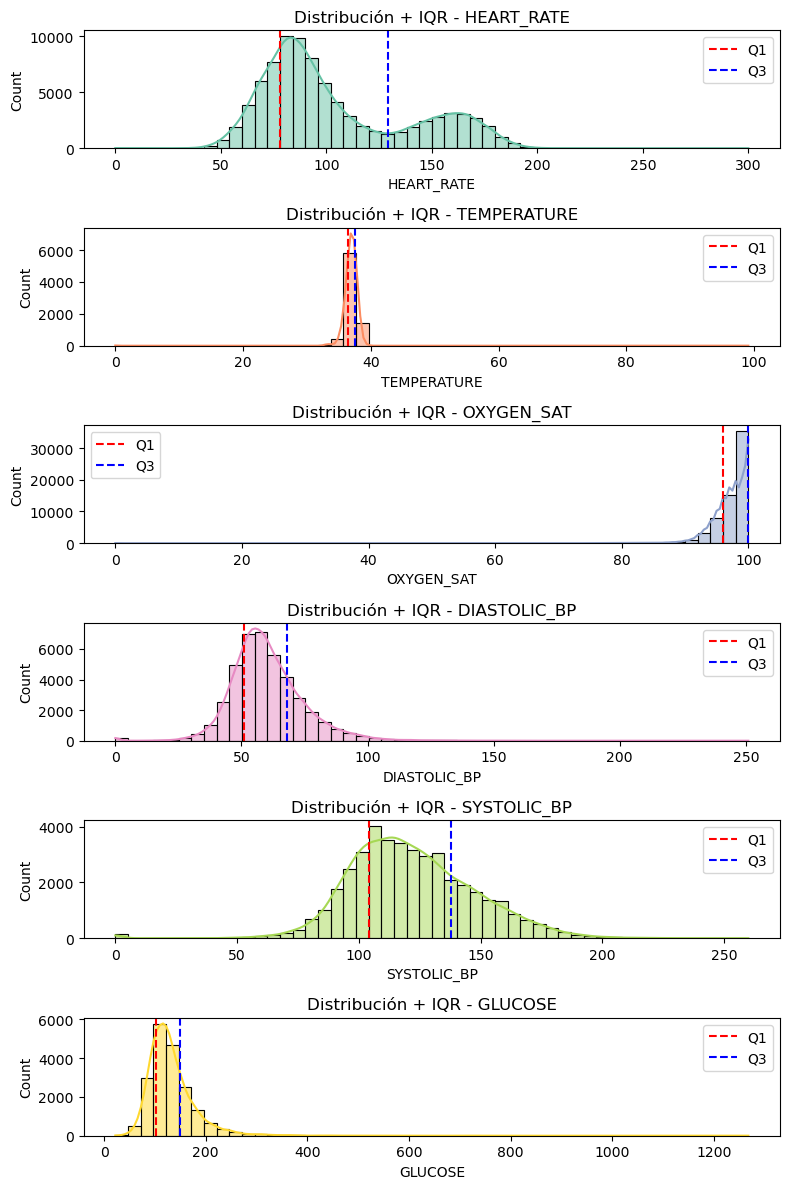

In [64]:
# Detectar outliers con IQR
outliers_iqr = {}

for col in biomarcadores:
    Q1 = df_acotado[col].quantile(0.25)
    Q3 = df_acotado[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    mask_outliers = (df_acotado[col] < lower_bound) | (df_acotado[col] > upper_bound)
    outliers_iqr[col] = mask_outliers.sum()
    
print("Cantidad de outliers por IQR:")
print(outliers_iqr)

# --- Graficar histogramas con outliers resaltados ---
colors = sns.color_palette("Set2", len(biomarcadores))
fig, axes = plt.subplots(len(biomarcadores), 1, figsize=(8, 12))
for i, col in enumerate(biomarcadores):
    sns.histplot(df_acotado[col], bins=50, ax=axes[i], color=colors[i], kde=True)
    axes[i].axvline(df_acotado[col].quantile(0.25), color="red", linestyle="--", label="Q1")
    axes[i].axvline(df_acotado[col].quantile(0.75), color="blue", linestyle="--", label="Q3")
    axes[i].legend()
    axes[i].set_title(f"Distribución + IQR - {col}")
plt.tight_layout()
plt.show()


Al aplicar la técnica basada en el rango intercuartílico (IQR) para la detección de outliers, se observa que los límites definidos por este método resultan más estrechos en comparación con los umbrales de Z-score. Esto implica que el IQR amplía la detección de valores atípicos, ya que clasifica como outliers a un mayor número de observaciones que se encuentran fuera del rango

En particular, se destaca que el rango definido por el IQR puede ser incluso más restrictivo que el umbral de Z-score > 2, lo que lo convierte en un criterio más sensible para identificar variaciones en los biomarcadores. Sin embargo, esta misma sensibilidad puede conducir a la clasificación de un número mayor de observaciones como atípicas, aun cuando algunas de ellas no representen un riesgo clínico crítico.

### Trabajo futuro con los datos atípicos

En este proyecto, la detección de outliers no tiene como propósito eliminarlos, sino **aprovecharlos como señales de alerta temprana**.  
Dado que los valores atípicos en biomarcadores pueden corresponder a eventos clínicamente relevantes, se busca conservarlos y darles un tratamiento adecuado en el análisis.

A futuro, el trabajo con estos datos incluirá:

- **Mejorar los métodos de detección de outliers**: combinar enfoques estadísticos (Z-score, IQR) con métodos basados en machine learning para identificar patrones más complejos.  
- **Ordenar y depurar el dataset**: manejo de datos faltantes, imputación de valores cuando sea pertinente y organización cronológica para asegurar coherencia en la evolución de los biomarcadores.  
- **Validación clínica de los outliers detectados**: revisar con criterios médicos si los valores atípicos corresponden a errores de registro, condiciones transitorias o verdaderos estados críticos.  
- **Integración en un sistema de alerta temprana**: usar los outliers detectados como disparadores de notificaciones que apoyen la vigilancia del estado de los pacientes en entornos hospitalarios.  

En conclusión, los valores atípicos se consideran un insumo clave del análisis y no un problema a eliminar, ya que representan la base para el desarrollo de un sistema de alerta temprana más robusto.
